In [20]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.sparse # Keep this or add it

# Path to the generated pseudobulk file
# Adjust this path if your output directory structure is different
# or if you are running this notebook from a different location.
output_dir_base = "/mnt/czi-sci-ai/intrinsic-variation-gene-ex/rnaseq/standardized_data/gtex_single_cell_runs"
# Find the latest run directory (or specify a particular run)
latest_run_dir = sorted([d for d in Path(output_dir_base).iterdir() if d.is_dir() and d.name.startswith('run_')])[-1]
pseudobulk_file = latest_run_dir / "gtex_scrnaseq_pseudobulk_standardized.h5ad"

print(f"Loading pseudobulk AnnData from: {pseudobulk_file}")
adata_pb = sc.read_h5ad(pseudobulk_file)

print("\n--- Pseudobulk AnnData Overview ---")
print(adata_pb)



Loading pseudobulk AnnData from: /mnt/czi-sci-ai/intrinsic-variation-gene-ex/rnaseq/standardized_data/gtex_single_cell_runs/run_20250520_182153/gtex_scrnaseq_pseudobulk_standardized.h5ad

--- Pseudobulk AnnData Overview ---
AnnData object with n_obs × n_vars = 228 × 17695
    obs: 'subject_id', 'cell_type', 'tissue', 'sex', 'age', 'dataset', 'data_type', 'species', 'species_ontology', 'tissue_ontology', 'developmental_stage_ontology', 'assay_ontology', 'expression_unit', 'n_cells_in_pseudobulk'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'Approved name', 'Status', 'Previous symbols', 'Alias symbols', 'gene_include', 'n_cells', 'pseudobulk_variance', 'gene_id'
    uns: 'assay_ontology', 'creation_date', 'data_type', 'dataset_version', 'doi', 'extras', 'gencode_version', 'harmonized_gencode_version', 'harmonized_reference_genome', 'label', 'license_terms', 'metad



--- .obs (Pseudobulk Samples) ---
Shape of .obs: (228, 14)
Columns in .obs: ['subject_id', 'cell_type', 'tissue', 'sex', 'age', 'dataset', 'data_type', 'species', 'species_ontology', 'tissue_ontology', 'developmental_stage_ontology', 'assay_ontology', 'expression_unit', 'n_cells_in_pseudobulk']

First 5 rows of .obs:
                                            subject_id  \
01_Adipocyte                                        01   
01_Endothelial cell (cardiac microvascular)         01   
01_Endothelial cell (lymphatic)                     01   
01_Endothelial cell (vascular) I                    01   
01_Endothelial cell (vascular) II                   01   

                                                                            cell_type  \
01_Adipocyte                                                                Adipocyte   
01_Endothelial cell (cardiac microvascular)  Endothelial cell (cardiac microvascular)   
01_Endothelial cell (lymphatic)                          Endoth

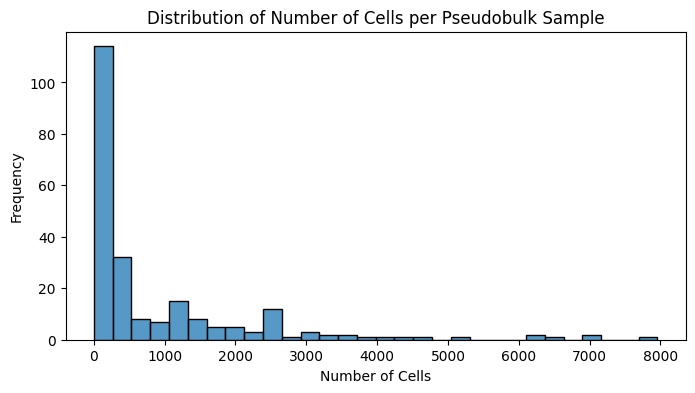


Unique values in .obs categorical columns:
  subject_id (top 5 unique): ['01', '02', '03', '04']
Categories (4, object): ['01', '02', '03', '04']
    Total unique values for subject_id: 4
  cell_type (top 5 unique): ['Adipocyte', 'Endothelial cell (cardiac microvascular)', 'Endothelial cell (lymphatic)', 'Endothelial cell (vascular) I', 'Endothelial cell (vascular) II']
Categories (74, object): ['Adipocyte', 'Endothelial cell (cardiac microvascular)', 'Endothelial cell (lymphatic)', 'Endothelial cell (vascular) I', ..., 'Sebaceous gland cell (SEC14L6+)', 'Sweat gland cell', 'Unknown (ATP1B3-GJB6)', 'Unknown (SFN-GJA1)']
    Total unique values for cell_type: 74
  tissue (top 5 unique): ['skeletal muscle', 'heart', 'prostate', 'lung', 'esophagus mucosa']
Categories (8, object): ['breast', 'esophagus mucosa', 'esophagus muscularis', 'heart', 'lung', 'prostate', 'skeletal muscle', 'skin']
    Total unique values for tissue: 8
  sex (top 5 unique): ['male', 'female']
Categories (2, object

/tmp/ipykernel_5410/3205585931.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata_pb.obs.groupby('tissue')['cell_type'].nunique().nlargest(5))
/tmp/ipykernel_5410/3205585931.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata_pb.obs.groupby('subject_id')['cell_type'].nunique().nlargest(5))


In [9]:
# --- 1. Inspect .obs (Observations/Samples) ---
print("\n\n--- .obs (Pseudobulk Samples) ---")
print(f"Shape of .obs: {adata_pb.obs.shape}")
print(f"Columns in .obs: {adata_pb.obs.columns.tolist()}")
print("\nFirst 5 rows of .obs:")
print(adata_pb.obs.head())

# Check data types in .obs
print("\nData types of .obs columns:")
print(adata_pb.obs.dtypes)

# Check for missing values in key .obs columns
key_obs_cols = ['subject_id', 'cell_type', 'tissue', 'sex', 'age', 
                'tissue_ontology', 'n_cells_in_pseudobulk', 'dataset', 'expression_unit']
print("\nMissing values in key .obs columns:")
for col in key_obs_cols:
    if col in adata_pb.obs.columns:
        missing_count = adata_pb.obs[col].isna().sum()
        print(f"  {col}: {missing_count} missing ({(missing_count/len(adata_pb.obs))*100:.2f}%)")
    else:
        print(f"  {col}: Column not found")

# Distribution of n_cells_in_pseudobulk
if 'n_cells_in_pseudobulk' in adata_pb.obs.columns:
    print("\nDistribution of n_cells_in_pseudobulk:")
    print(adata_pb.obs['n_cells_in_pseudobulk'].describe())
    plt.figure(figsize=(8, 4))
    sns.histplot(adata_pb.obs['n_cells_in_pseudobulk'], bins=30)
    plt.title('Distribution of Number of Cells per Pseudobulk Sample')
    plt.xlabel('Number of Cells')
    plt.ylabel('Frequency')
    plt.show()

# Unique values for key categorical columns
print("\nUnique values in .obs categorical columns:")
for col in ['subject_id', 'cell_type', 'tissue', 'sex', 'age', 'tissue_ontology', 'dataset', 'expression_unit']:
    if col in adata_pb.obs.columns:
        unique_vals = adata_pb.obs[col].unique()
        print(f"  {col} (top 5 unique): {unique_vals[:5]}")
        print(f"    Total unique values for {col}: {len(unique_vals)}")

# Cross-tabulation examples
if 'tissue' in adata_pb.obs.columns and 'cell_type' in adata_pb.obs.columns:
    print("\nNumber of cell types per tissue (top 5 tissues):")
    print(adata_pb.obs.groupby('tissue')['cell_type'].nunique().nlargest(5))

if 'subject_id' in adata_pb.obs.columns and 'cell_type' in adata_pb.obs.columns:
    print("\nNumber of cell types profiled per subject (top 5 subjects):")
    print(adata_pb.obs.groupby('subject_id')['cell_type'].nunique().nlargest(5))
    print(f"Total unique subject_ids: {adata_pb.obs['subject_id'].nunique()}")




--- .var (Genes) ---
Shape of .var: (17695, 20)
Columns in .var: ['gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'Approved name', 'Status', 'Previous symbols', 'Alias symbols', 'gene_include', 'n_cells', 'pseudobulk_variance', 'gene_id']

First 5 rows of .var:
                   gene_ids Chromosome          Source   Start     End Strand  \
FO538757.2  ENSG00000279457          1         ensembl  184922  200322      -   
SAMD11      ENSG00000187634          1  ensembl_havana  924879  944581      +   
NOC2L       ENSG00000188976          1  ensembl_havana  944203  959309      -   
KLHL17      ENSG00000187961          1  ensembl_havana  960586  965715      +   
PLEKHN1     ENSG00000187583          1  ensembl_havana  966496  975865      +   

             gene_name     gene_source    gene_biotype  gene_length  \
FO538757.2  FO538757.2         ensembl  protein_coding        15

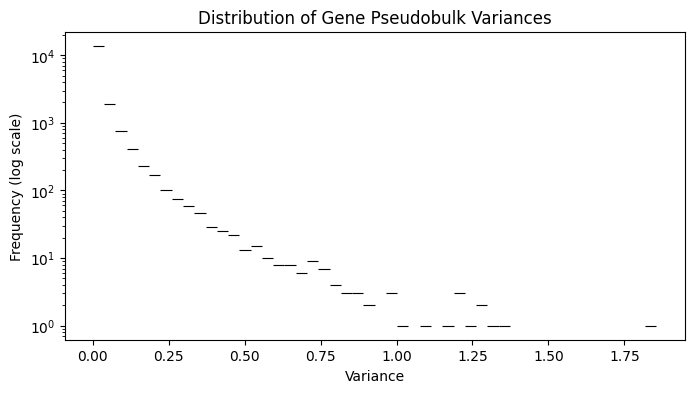


Top 5 genes with highest pseudobulk_variance:
         gene_name  pseudobulk_variance
LINGO1      LINGO1             1.855795
TTN            TTN             1.357092
RASGEF1B  RASGEF1B             1.308807
RBMS3        RBMS3             1.297307
PTPRG        PTPRG             1.285330

Sample gene IDs (index): ['FO538757.2', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1']
Are gene IDs (index) Ensembl format (no version)? False

Sample gene_ids (column): ['FO538757.2', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1']
Are 'gene_id' column values Ensembl format (no version)? False


In [10]:

# --- 2. Inspect .var (Variables/Genes) ---
print("\n\n--- .var (Genes) ---")
print(f"Shape of .var: {adata_pb.var.shape}")
print(f"Columns in .var: {adata_pb.var.columns.tolist()}")
print("\nFirst 5 rows of .var:")
print(adata_pb.var.head())

# Check 'pseudobulk_variance'
if 'pseudobulk_variance' in adata_pb.var.columns:
    print("\nDistribution of 'pseudobulk_variance':")
    print(adata_pb.var['pseudobulk_variance'].describe())
    
    # Plot highly variable genes (HVGs can be identified later based on this)
    plt.figure(figsize=(8, 4))
    sns.histplot(adata_pb.var['pseudobulk_variance'].dropna(), bins=50, log_scale=(False, True)) # Log scale for y-axis
    plt.title('Distribution of Gene Pseudobulk Variances')
    plt.xlabel('Variance')
    plt.ylabel('Frequency (log scale)')
    plt.show()
    
    print("\nTop 5 genes with highest pseudobulk_variance:")
    print(adata_pb.var.nlargest(5, 'pseudobulk_variance')[['gene_name', 'pseudobulk_variance']]) # Assuming 'gene_name' exists
else:
    print("\n'pseudobulk_variance' column not found in .var")

# Check gene ID format (should be Ensembl without version)
if adata_pb.var.index.name == 'feature_id' or True: # Assuming index is gene IDs
    print(f"\nSample gene IDs (index): {adata_pb.var.index[:5].tolist()}")
    is_ensembl = all(str(gid).startswith("ENSG") and "." not in str(gid) for gid in adata_pb.var.index[:100])
    print(f"Are gene IDs (index) Ensembl format (no version)? {is_ensembl}")

if 'gene_id' in adata_pb.var.columns:
    print(f"\nSample gene_ids (column): {adata_pb.var['gene_id'][:5].tolist()}")
    is_ensembl_col = all(str(gid).startswith("ENSG") and "." not in str(gid) for gid in adata_pb.var['gene_id'][:100])
    print(f"Are 'gene_id' column values Ensembl format (no version)? {is_ensembl_col}")



In [23]:

# --- 3. Inspect .X (Expression Matrix) ---
print("\n\n--- .X (Expression Matrix) ---")
print(f"Shape of .X: {adata_pb.X.shape}")
print(f"Data type of .X: {adata_pb.X.dtype}")
print(f"Is .X sparse? {scipy.sparse.issparse(adata_pb.X)}") # Use the full path

# Min, Max, Mean of expression values (sample a few)
print("\nExpression matrix value statistics (sampling first 5 samples, first 5 genes):")
sample_X = adata_pb.X[:5, :5].toarray() if scipy.sparse.issparse(adata_pb.X) else adata_pb.X[:5, :5]
print(f"  Sample values:\n{sample_X}")
print(f"  Min value in sample: {np.min(sample_X)}")
print(f"  Max value in sample: {np.max(sample_X)}")
print(f"  Mean value in sample: {np.mean(sample_X)}")
print(f"  Overall min in .X: {np.min(adata_pb.X)}")
print(f"  Overall max in .X: {np.max(adata_pb.X)}")
print(f"  Overall mean in .X: {np.mean(adata_pb.X)}")

# Check for NaNs or Infs in .X
if scipy.sparse.issparse(adata_pb.X):
    has_nans = np.isnan(adata_pb.X.data).any()
    has_infs = np.isinf(adata_pb.X.data).any()
else:
    has_nans = np.isnan(adata_pb.X).any()
    has_infs = np.isinf(adata_pb.X).any()
print(f"Contains NaNs in .X? {has_nans}")
print(f"Contains Infs in .X? {has_infs}")





--- .X (Expression Matrix) ---
Shape of .X: (228, 17695)
Data type of .X: float32
Is .X sparse? False

Expression matrix value statistics (sampling first 5 samples, first 5 genes):
  Sample values:
[[0.3883171  0.0050963  0.05718869 0.03505182 0.        ]
 [0.3055486  0.         0.01985856 0.00625933 0.        ]
 [0.2581623  0.00126289 0.06397397 0.01843374 0.00397592]
 [0.19128959 0.01476498 0.05610571 0.01234962 0.00403775]
 [0.14747691 0.00360902 0.03518901 0.00590927 0.00215375]]
  Min value in sample: 0.0
  Max value in sample: 0.3883171081542969
  Mean value in sample: 0.0654405951499939
  Overall min in .X: 0.0
  Overall max in .X: 6.86001443862915
  Overall mean in .X: 0.10680338740348816
Contains NaNs in .X? False
Contains Infs in .X? False


In [24]:

# --- 4. Inspect .uns (Unstructured Annotation) ---
print("\n\n--- .uns (Unstructured Annotation) ---")
print(f"Keys in .uns: {list(adata_pb.uns.keys())}")

# Print specific .uns fields
for key in ['dataset_info', 'pseudobulking_parameters', 'creation_date', 
            'harmonized_gencode_version', 'harmonized_reference_genome',
            'gtex_scrnaseq_metadata_source_details']: # Check if this key was created by apply_dataset_specific_metadata
    if key in adata_pb.uns:
        print(f"\n.uns['{key}']: ")
        # Pretty print if dict or list
        if isinstance(adata_pb.uns[key], (dict, list)):
            import json
            print(json.dumps(adata_pb.uns[key], indent=2, default=str))
        else:
            print(adata_pb.uns[key])
    else:
        print(f"\n.uns['{key}']: Not found")
        
if 'metadata_source' in adata_pb.uns and 'citation' in adata_pb.uns['metadata_source']:
     print(f"\n.uns['metadata_source']['citation']: {adata_pb.uns['metadata_source']['citation']}")

# --- Alignment with Expectations (GTEx Single-Cell v8 Atlas) ---
print("\n\n--- Alignment with GTEx Single-Cell Atlas (v8, Eraslan et al. 2022) ---")
# From your provided text:
# Donors profiled: 16
# Tissues analyzed: 8 (heart, lung, esophagus muscularis, prostate, skeletal muscle, esophagus mucosa, breast, skin)
# Total cells sequenced: 209,126
# Distinct cell types identified: 44 (this might be after their filtering/analysis)
# Pseudobulk samples = num_donors * num_cell_types_per_donor_tissue (roughly)

expected_donors = 16 # The H5AD is from 4 donors only for the 8 tissues public atlas
# The public GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad file contains data from 4 donors across 8 tissues.
# The 16 donors and 44 cell types likely refers to a larger, perhaps non-public or fully processed version of the atlas.
# Let's use the known public data specs for the 8-tissue atlas.
# The paper "Single-nucleus cross-tissue molecular reference maps toward understanding disease gene function" (Eraslan et al.)
# states "We profiled eight tissues (breast, esophagus muscularis, esophagus mucosa, heart, lung, prostate, skeletal muscle, and skin) from four human donors."
# The public H5AD `GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad` metadata often shows `individual: ['01', '02', '03', '04']`

num_donors_processed = adata_pb.obs['subject_id'].nunique()
print(f"Number of unique donors in pseudobulk data: {num_donors_processed}")
if num_donors_processed == 4:
    print(f"  -> Matches expectation for the 8-tissue public atlas (4 donors).")
else:
    print(f"  -> MISMATCH: Expected 4 donors for the public 8-tissue atlas, got {num_donors_processed}.")

tissues_processed = adata_pb.obs['tissue'].unique()
print(f"\nTissues processed ({len(tissues_processed)}): {sorted(list(tissues_processed))}")
expected_tissues_8_atlas = sorted(['breast', 'esophagus mucosa', 'esophagus muscularis', 'heart', 'lung', 'prostate', 'skeletal muscle', 'skin'])
if sorted(list(tissues_processed)) == expected_tissues_8_atlas:
    print(f"  -> Matches expectation for the 8-tissue public atlas.")
else:
    print(f"  -> MISMATCH: Tissues do not perfectly match the expected 8 for the public atlas.")
    print(f"    Expected: {expected_tissues_8_atlas}")


num_cell_types_processed = adata_pb.obs['cell_type'].nunique()
print(f"\nNumber of unique cell types in pseudobulk data: {num_cell_types_processed}")
# The "44 distinct cell types" is from a broader analysis of the full 16-donor dataset.
# For the 4-donor, 8-tissue public set, the number will be different but should be substantial.
# The log showed: Categories (74, object) for cell_type from single cell data.
# After pseudobulking, it will be the number of unique cell types present in the `adata_pb.obs`.
if num_cell_types_processed > 30 and num_cell_types_processed < 100 : # A reasonable range for this subset
    print(f"  -> Number of cell types ({num_cell_types_processed}) seems reasonable for this subset of the atlas.")
else:
    print(f"  -> Number of cell types ({num_cell_types_processed}) might be unexpected. Check definition.")


total_pseudobulk_samples = len(adata_pb)
print(f"\nTotal pseudobulk samples (donor x cell_type combinations): {total_pseudobulk_samples}")
# From your log, pseudobulk samples = 228
if total_pseudobulk_samples == 228:
    print(f"  -> Matches the count from the processing log (228).")
else:
    print(f"  -> MISMATCH with processing log count. Log showed 228.")


# Check Gencode version from .uns
gencode_v_uns = adata_pb.uns.get('harmonized_gencode_version', 'Unknown')
print(f"\nHarmonized Gencode version in .uns: v{gencode_v_uns}")
if str(gencode_v_uns) == '24':
    print("  -> Matches expectation (harmonized to v24).")
else:
    print(f"  -> MISMATCH: Expected v24, got v{gencode_v_uns}.")

# Reference genome
ref_genome_uns = adata_pb.uns.get('harmonized_reference_genome', 'Unknown')
print(f"\nHarmonized Reference genome in .uns: {ref_genome_uns}")
if str(ref_genome_uns) == 'hg38':
    print("  -> Matches expectation (harmonized to hg38).")
else:
    print(f"  -> MISMATCH: Expected hg38, got {ref_genome_uns}.")

print("\n--- End of Inspection ---")



--- .uns (Unstructured Annotation) ---
Keys in .uns: ['assay_ontology', 'creation_date', 'data_type', 'dataset_version', 'doi', 'extras', 'gencode_version', 'harmonized_gencode_version', 'harmonized_reference_genome', 'label', 'license_terms', 'metadata_sources', 'platform', 'pseudobulking_parameters', 'reference_genome', 'rna_seq_protocol', 'version']

.uns['dataset_info']: Not found

.uns['pseudobulking_parameters']: 
{
  "aggregation_method": "mean",
  "grouped_by": "['subject_id' 'cell_type']",
  "source_h5ad": "GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad"
}

.uns['creation_date']: 
2025-05-20

.uns['harmonized_gencode_version']: 
v24

.uns['harmonized_reference_genome']: 
hg38

.uns['gtex_scrnaseq_metadata_source_details']: Not found


--- Alignment with GTEx Single-Cell Atlas (v8, Eraslan et al. 2022) ---
Number of unique donors in pseudobulk data: 4
  -> Matches expectation for the 8-tissue public atlas (4 donors).

Tissues processed (8): ['breast', 'esophagus mucosa'